## Managing Imports

In [1]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler


## Initialising Dataset + Extra Processing 
Nothing too difficult here. Just for notice, scope tuning (will store scope - 1 hours of data for prediction)

In [2]:
scope = 48

Working with data. You can see all featue selection here!

In [3]:
# Load data
data = pd.read_csv("Preprocessed_Solar_Power_Data_v3.csv")

# drop NA rows
data = data.dropna()

lagged_cols_demand = {f"lag_{lag}": data["TOTALDEMAND"].shift(lag) for lag in range(1,scope)}
lagged_df_demand = pd.DataFrame(lagged_cols_demand, index=data.index)
data_demand = pd.concat([data, lagged_df_demand], axis=1).dropna()

X1 = data_demand[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS", "WEEKDAY_SIN", "WEEKDAY_COS",
] + [f"lag_{i}" for i in range(1,scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y1 = data_demand["TOTALDEMAND"]

lagged_cols_irr = {f"lag_{lag}": data["ALLSKY_SFC_SW_DWN"].shift(lag) for lag in range(1,scope)}
lagged_df_irr = pd.DataFrame(lagged_cols_irr, index=data.index)
data_irr = pd.concat([data, lagged_df_irr], axis=1).dropna()

X2 = data_irr[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS", "WEEKDAY_SIN", "WEEKDAY_COS",
] + [f"lag_{i}" for i in range(1,scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y2 = data_irr["ALLSKY_SFC_SW_DWN"]
q3 = np.percentile(y2, 85)
print(q3)


529.3739999999999


## Run this before any test!
Also, I will give a quick overview of all of the relevant graphs in case!

In [4]:
def metrics(y, X, pipeline):
    tscv = TimeSeriesSplit(n_splits=12)

    # Reset inside the function
    train_metrics = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    test_metrics  = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_test_pred  = pipeline.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = mse_train ** 0.5
        r2_train = r2_score(y_train, y_train_pred)

        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = mse_test ** 0.5
        r2_test = r2_score(y_test, y_test_pred)

        train_metrics['MSE'].append(mse_train)
        train_metrics['MAE'].append(mae_train)
        train_metrics['RMSE'].append(rmse_train)
        train_metrics['R2'].append(r2_train)

        test_metrics['MSE'].append(mse_test)
        test_metrics['MAE'].append(mae_test)
        test_metrics['RMSE'].append(rmse_test)
        test_metrics['R2'].append(r2_test)

        print(f"Fold {fold+1}:")
        print(f"Train -> MSE: {mse_train:.2f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.2f}")
        print(f"Test  -> MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.2f}")
        print("______________")

    print("Average Training Metrics:")
    print({k: sum(v)/len(v) for k, v in train_metrics.items()})
    print("Average Testing Metrics:")
    print({k: sum(v)/len(v) for k, v in test_metrics.items()})

    residuals = y_test - y_test_pred

    spearman = stats.spearmanr(y_test, y_test_pred).correlation
    kendall = stats.kendalltau(y_test, y_test_pred).correlation
    print(f"Spearman ρ: {spearman:.3f}, Kendall τ: {kendall:.3f}")

    y_shuffled = y_test.sample(frac=1.0, random_state=42)
    r2_shuffled = r2_score(y_shuffled, y_test_pred)
    print(f"R² shuffled: {r2_shuffled:.3f}") 
    
    # Residual vs Predicted
    sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted")
    plt.show()

    # Distribution of residuals
    sns.histplot(residuals, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Residual Distribution")
    plt.show()

    # Q-Q Plot (normality check)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Select only numeric columns
    numeric_X = X.select_dtypes(include=['float64', 'int64'])

    # Correlation between each feature and the true target
    corr_with_target = numeric_X.corrwith(y).sort_values(ascending=False)
    plt.figure(figsize=(6,8))
    sns.barplot(x=corr_with_target, y=corr_with_target.index, orient='h')
    plt.title("Feature Correlation with Target (y)")
    plt.xlabel("Correlation Coefficient (Pearson)")
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(y_test.values, label="Actual")
    plt.plot(y_test_pred, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title("Actual vs Predicted Demand (Last Fold)")
    plt.show()

    corrs = X[[col for col in X.columns if col.startswith("lag_")]].corrwith(y)
    plt.plot(range(1, len(corrs) + 1), corrs)
    plt.title("Lag Correlation with Target")
    plt.show()    
    
    plt.plot(residuals)
    plt.title("Residuals over Time")
    plt.show()

    return pipeline


def metrics_no_train(y, X, pipeline):
    """Evaluate an already-trained pipeline on (X, y) without refitting."""
    y_pred = pipeline.predict(X)

    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y, y_pred)

    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    residuals = y - y_pred

    # Correlations
    spearman = stats.spearmanr(y, y_pred).correlation
    kendall = stats.kendalltau(y, y_pred).correlation
    print(f"Spearman ρ: {spearman:.3f}, Kendall τ: {kendall:.3f}")

    # Sanity check (R² vs shuffled)
    r2_shuffled = r2_score(y.sample(frac=1.0, random_state=42), y_pred)
    print(f"R² shuffled: {r2_shuffled:.3f}")

    # === Plots ===
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.show()

    sns.histplot(residuals, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Residual Distribution")
    plt.show()

    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Feature correlation
    numeric_X = X.select_dtypes(include=["float64", "int64"])
    corr_with_target = numeric_X.corrwith(y).sort_values(ascending=False)
    plt.figure(figsize=(6, 8))
    sns.barplot(x=corr_with_target, y=corr_with_target.index, orient='h')
    plt.title("Feature Correlation with Target (y)")
    plt.xlabel("Correlation Coefficient (Pearson)")
    plt.show()

    # Actual vs Predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y.values, label="Actual")
    plt.plot(y_pred, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title("Actual vs Predicted (Full Data)")
    plt.show()

    # Lag correlation if applicable
    lag_cols = [col for col in X.columns if col.startswith("lag_")]
    if lag_cols:
        corrs = X[lag_cols].corrwith(y)
        plt.plot(range(1, len(corrs) + 1), corrs)
        plt.title("Lag Correlation with Target")
        plt.show()

    plt.plot(residuals)
    plt.title("Residuals over Time")
    plt.show()

    plt.figure(figsize=(14, 10))
    top_features = corr_with_target.abs().sort_values(ascending=False).head(15).index
    corr_subset = X[top_features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_subset, annot=True, cmap="coolwarm", center=0)
    plt.title("Top 15 Features Correlation Matrix")
    plt.show()

    corrs = X[[c for c in X.columns if c.startswith("lag_")]].corrwith(y)
    plt.plot(range(1, len(corrs)+1), corrs)
    plt.axvline(48, color='red', linestyle='--', label='Chosen window')
    plt.xlabel("Lag (hours)")
    plt.ylabel("Correlation with target")
    plt.legend()
    plt.title("Autocorrelation decay of lag features")
    plt.show()



    return y_pred


## Initialising MLP Pipeline
Run this code to get MLP training (needs to run once to initialise everything)

In [5]:
Solar_Pipeline = None
Demand_Pipeline = None
test = None

def setMLP():
    global Solar_Pipeline, Demand_Pipeline, test

    Solar_Regressor = MLPRegressor(
        hidden_layer_sizes=(50,50),
        max_iter=4000,
        activation='relu',
        solver='adam',
        learning_rate_init=0.006247564316322379,
        learning_rate='adaptive',
        alpha=0.0007174815096277166,
        early_stopping=True,
        random_state=42
    )

    # Pipeline
    Solar_Pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('mlp', Solar_Regressor)
    ])

    Demand_Regressor = MLPRegressor(
        hidden_layer_sizes=(20,20,20,15),
        max_iter=4000,
        activation='relu',        
        solver='adam',
        learning_rate_init=0.004253303307632643, 
        learning_rate='adaptive',
        alpha=00.0006208342600258237,
        early_stopping=True,
        random_state=42
    )

    # Pipeline
    Demand_Pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('mlp', Demand_Regressor)
    ])

    return Solar_Pipeline, Demand_Pipeline, "MLP"

def setWNN():
    global Solar_Pipeline, test

    n_neighbors = 10
    weights = "distance"
    algorithm = "auto"
    metric = "minkowski"
    p = 2
    leaf_size = 30
    n_jobs = None
    metric_params = None

    # Use the same feature selection and PCA settings from your earlier code
    k_select = 50           # adjust if you use different feature count logic
    pca_components = 20     # adjust if needed
    random_state = 42

    Solar_Pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("select", SelectKBest(score_func=mutual_info_regression, k=k_select)),
        ("pca", PCA(n_components=pca_components, svd_solver="auto", random_state=random_state)),
        ("knn", KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            metric_params=metric_params,
            n_jobs=n_jobs,
            p=p
        )),
    ])

    return Solar_Pipeline, Solar_Pipeline, "WNN"

def setRF():
    global Solar_Pipeline, Demand_Pipeline, test

    # --- Parameters ---
    n_estimators_solar = 50
    n_estimators_demand = 100
    random_state = 42
    k_select = 50
    pca_components = 20

    # --- Regressors ---
    Solar_Regressor = RandomForestRegressor(
        n_estimators=n_estimators_solar,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features="log2",
        bootstrap=True,
        random_state=random_state
    )

    Demand_Regressor = RandomForestRegressor(
        n_estimators=n_estimators_demand,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features=10,
        bootstrap=True,
        random_state=random_state
    )

    # --- Pipelines ---
    Solar_Pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("select", SelectKBest(score_func=mutual_info_regression, k=k_select)),
        ("pca", PCA(n_components=pca_components, svd_solver="auto", random_state=random_state)),
        ("rf", Solar_Regressor)
    ])

    Demand_Pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("select", SelectKBest(score_func=mutual_info_regression, k=k_select)),
        ("pca", PCA(n_components=pca_components, svd_solver="auto", random_state=random_state)),
        ("rf", Demand_Regressor)
    ])

    return Solar_Pipeline, Demand_Pipeline, "RF"


def setModel(model):
    global Solar_Pipeline, Demand_Pipeline, test
    if model == "WNN":
        return setWNN()
    elif model == "MLP":
        return setMLP()
    elif model == "RF":
        return setRF()

    else:
        print("No model assigned.")

## Setting the Solar/Demand Pipelines
Run and modify model based on the model you want to obtain data for.

Training WNN Irradiance ML Model. Please wait...
Fold 1:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 254366.11, MAE: 368.54, RMSE: 504.35, R2: 0.82
______________
Fold 2:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 184129.52, MAE: 294.47, RMSE: 429.10, R2: 0.90
______________
Fold 3:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 92249.84, MAE: 222.85, RMSE: 303.73, R2: 0.93
______________
Fold 4:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 132674.37, MAE: 260.03, RMSE: 364.24, R2: 0.91
______________
Fold 5:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 89250.78, MAE: 222.39, RMSE: 298.75, R2: 0.94
______________
Fold 6:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 129585.97, MAE: 256.79, RMSE: 359.98, R2: 0.91
______________
Fold 7:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 98046.15, MAE: 229.86, RMSE: 313.12, R2: 0.91
______________
Fo

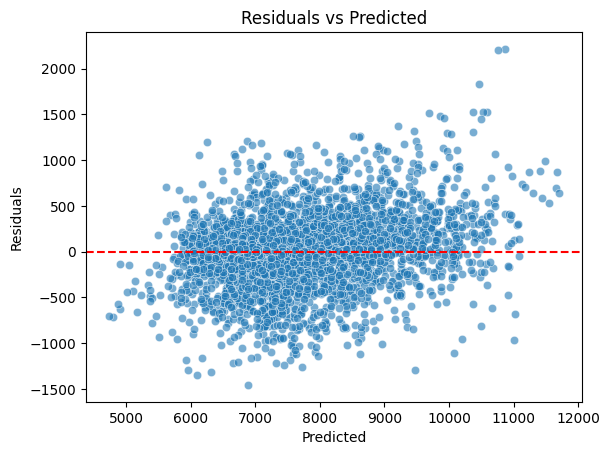

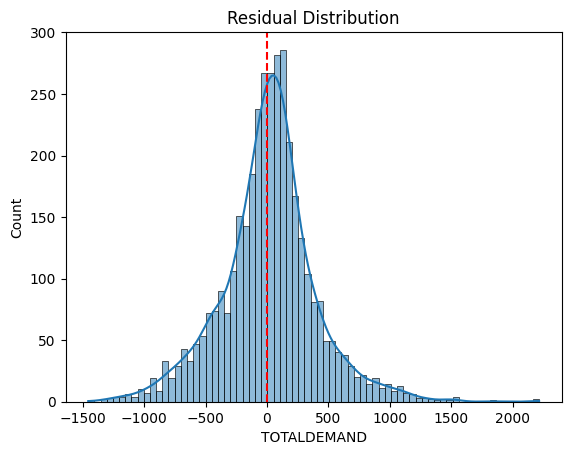

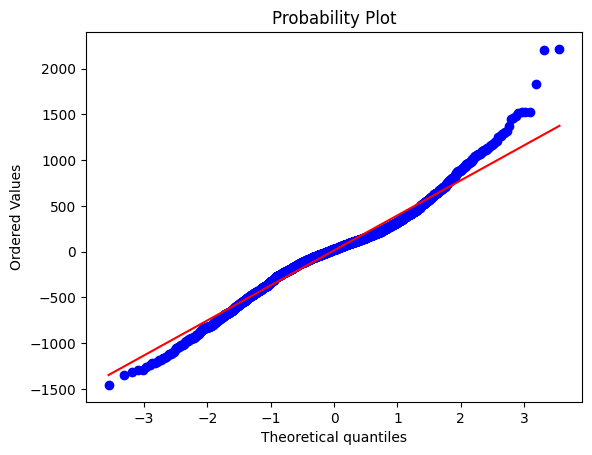

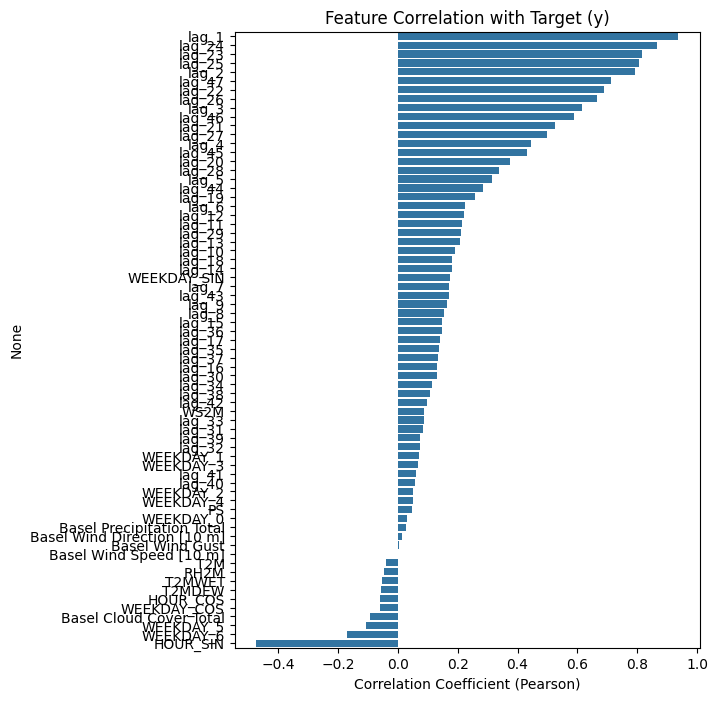

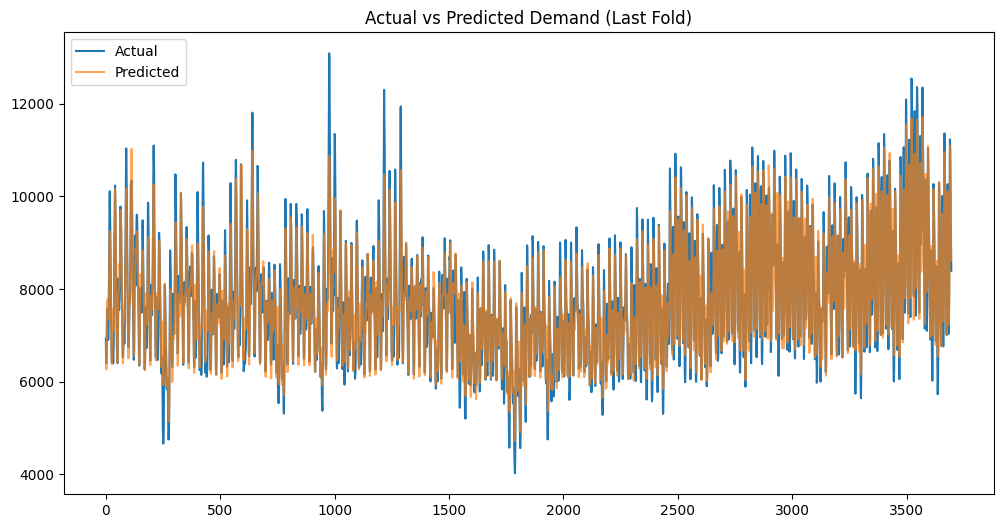

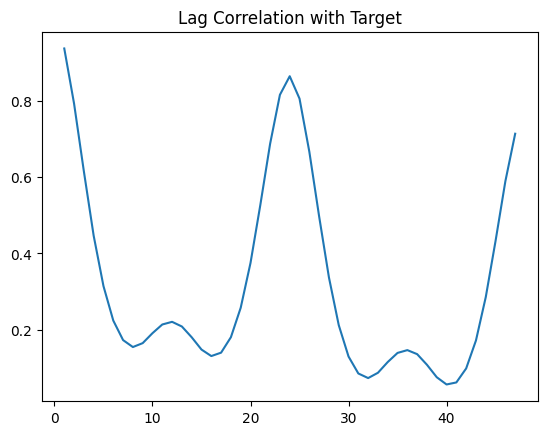

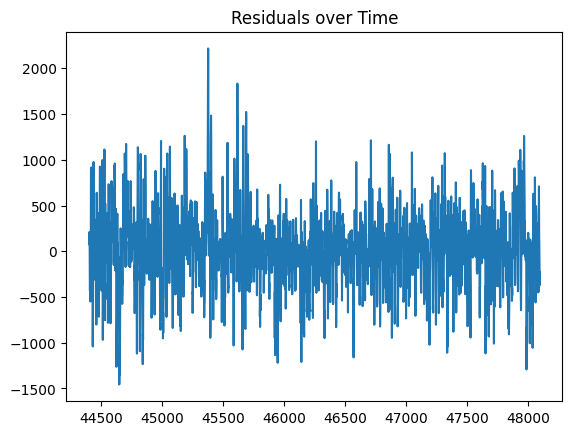

Training WNN Demand ML Model. Please wait...
Fold 1:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 3472.65, MAE: 29.65, RMSE: 58.93, R2: 0.94
______________
Fold 2:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 6304.88, MAE: 44.83, RMSE: 79.40, R2: 0.94
______________
Fold 3:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 1311.91, MAE: 16.75, RMSE: 36.22, R2: 0.97
______________
Fold 4:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 5050.32, MAE: 39.30, RMSE: 71.07, R2: 0.95
______________
Fold 5:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 2690.31, MAE: 25.11, RMSE: 51.87, R2: 0.95
______________
Fold 6:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 3733.11, MAE: 31.24, RMSE: 61.10, R2: 0.96
______________
Fold 7:
Train -> MSE: 0.00, MAE: 0.00, RMSE: 0.00, R2: 1.00
Test  -> MSE: 3840.05, MAE: 31.75, RMSE: 61.97, R2: 0.95
______________
Fold 8:
Train -> MSE: 0.00, MAE

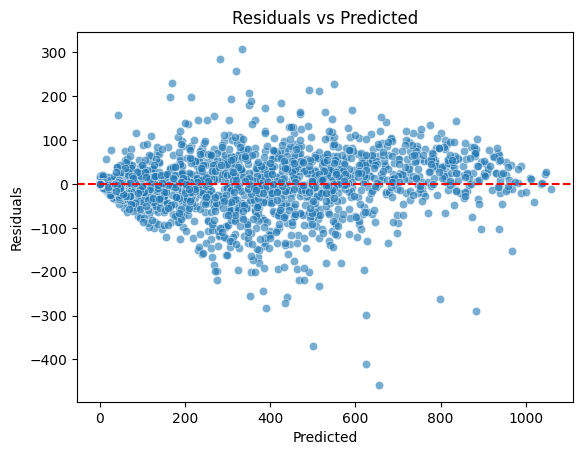

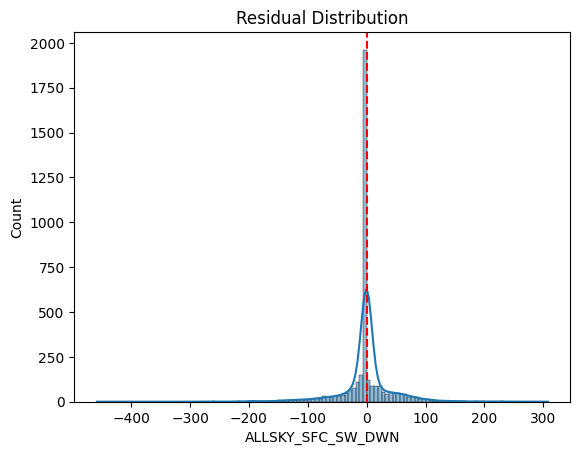

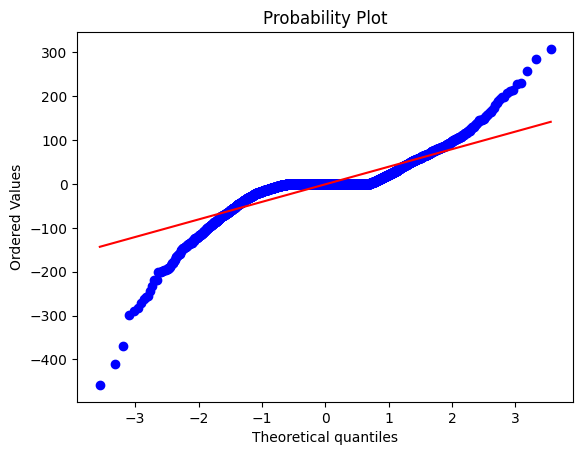

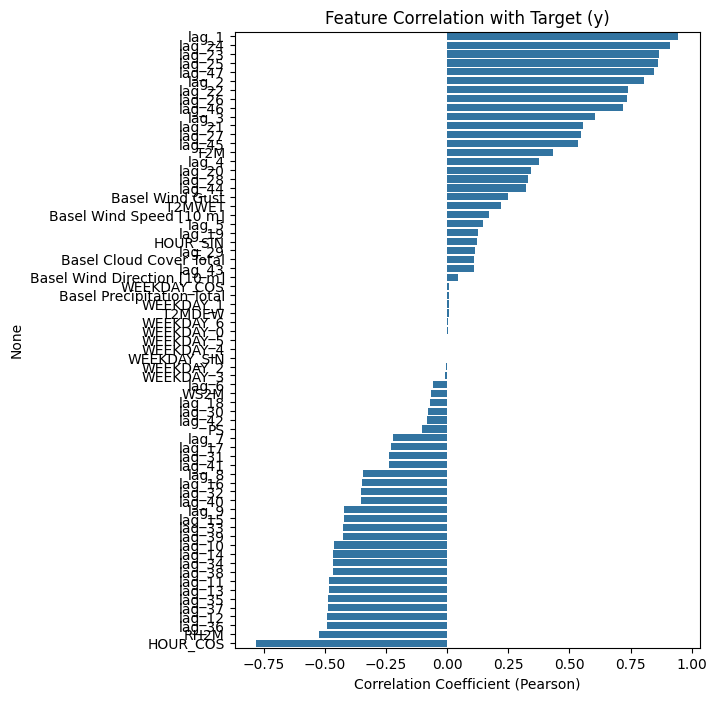

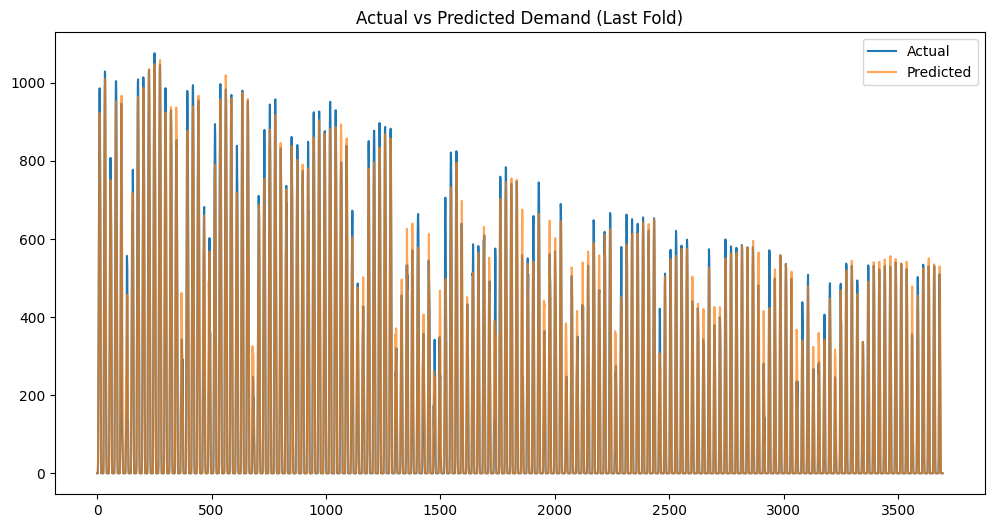

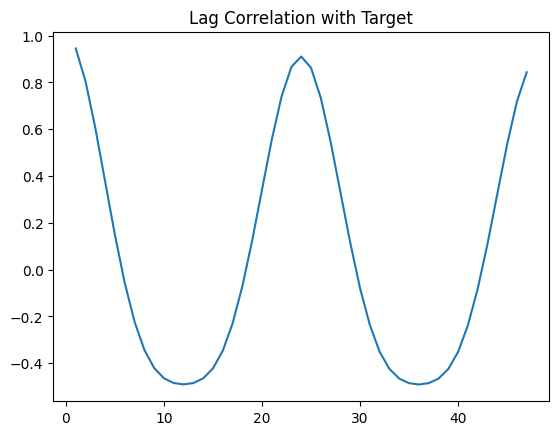

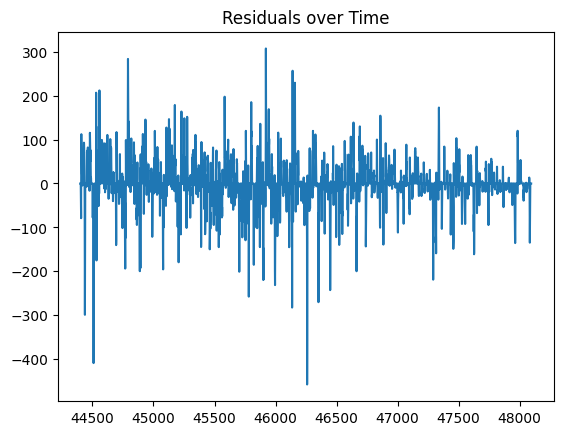

In [6]:
# Choose between "WNN", "RF", "MLP"
model = "WNN"
Solar_Pipeline, Demand_Pipeline, test = setModel(model)
print(f"Training {test} Irradiance ML Model. Please wait...")
demandModel = metrics(y1, X1, Demand_Pipeline)
print(f"Training {test} Demand ML Model. Please wait...")
SolarModel = metrics(y2, X2, Solar_Pipeline)




## Creating new dataset (uses 2024-2025)
Run once before saving the csv!

In [7]:
# Load first dataset
df = pd.read_csv("Preprocessed_Solar_Power_Data_24-25_v1.csv").dropna()

lagged_cols_demand = {f"lag_{lag}": df["TOTALDEMAND"].shift(lag) for lag in range(1,scope)}
lagged_df_demand = pd.DataFrame(lagged_cols_demand, index=df.index)
data_demand = pd.concat([df, lagged_df_demand], axis=1).dropna()

X1_ = data_demand[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS", "WEEKDAY_SIN", "WEEKDAY_COS",
] + [f"lag_{i}" for i in range(1,scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y1_ = data_demand["TOTALDEMAND"]

lagged_cols_irr = {f"lag_{lag}": df["ALLSKY_SFC_SW_DWN"].shift(lag) for lag in range(1,scope)}
lagged_df_irr = pd.DataFrame(lagged_cols_irr, index=df.index)
data_irr = pd.concat([df, lagged_df_irr], axis=1).dropna()

X2_ = data_irr[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS", "WEEKDAY_SIN", "WEEKDAY_COS",
] + [f"lag_{i}" for i in range(1,scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y2_ = data_irr["ALLSKY_SFC_SW_DWN"]

print(len(df),y2_)


8760 47      0.0
48      0.0
49      0.0
50      0.0
51      0.0
       ... 
8755    0.0
8756    0.0
8757    0.0
8758    0.0
8759    0.0
Name: ALLSKY_SFC_SW_DWN, Length: 8713, dtype: float64


T2M 18.738164373868344 17.715895787903133
T2MDEW 13.577827634289996 8.06933891885688
T2MWET 16.157983516826576 12.892637438310569
RH2M 73.15182501196695 59.20469643062091
PS 101.30117775604072 97.60015494089293
WS2M 3.223944098732544 2.5504200619763573
Basel Wind Gust 20.32851749114862 27.40609434178813
Basel Wind Direction [10 m] 163.16017059378345 181.68690462527258
Basel Precipitation Total 0.09418718391641866 0.12483645127969699
Basel Wind Speed [10 m] 7.411219011350913 12.739710776999885
Basel Cloud Cover Total 46.79229963339466 54.0872259841616
HOUR_SIN -1.1626968844125346e-17 -8.766595213383538e-18
HOUR_COS 2.0812087660458096e-05 0.00011477103179152035
WEEKDAY_SIN 2.0290285170988678e-05 0.002063826936389832
WEEKDAY_COS -4.6311251838162035e-06 -0.001645847061029617
lag_1 7752.142981123436 7423.498898198095
lag_2 7752.125365148078 7423.550918168255
lag_3 7752.1038406626585 7423.6439136921845
lag_4 7752.071043309956 7423.747817054975
lag_5 7752.0314576786195 7423.857378629635
lag_6

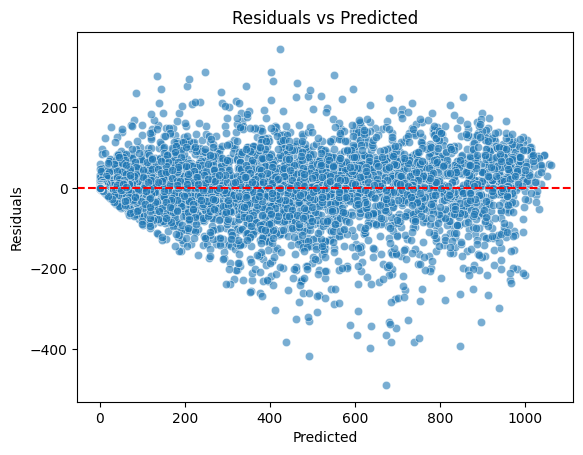

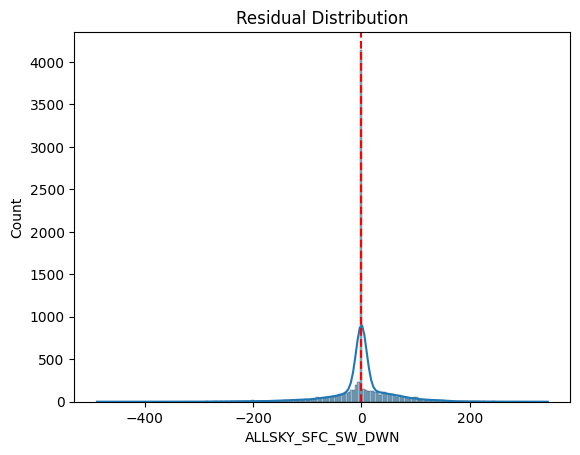

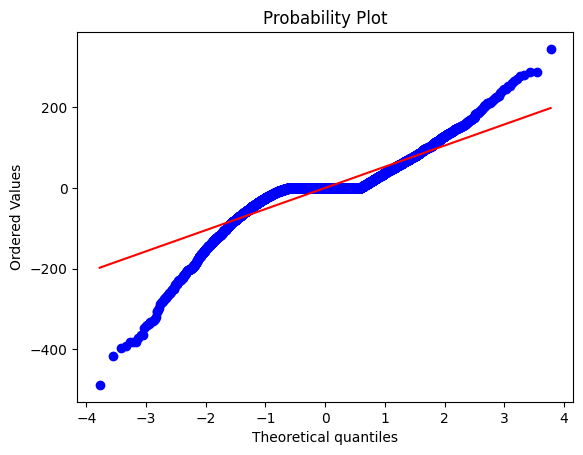

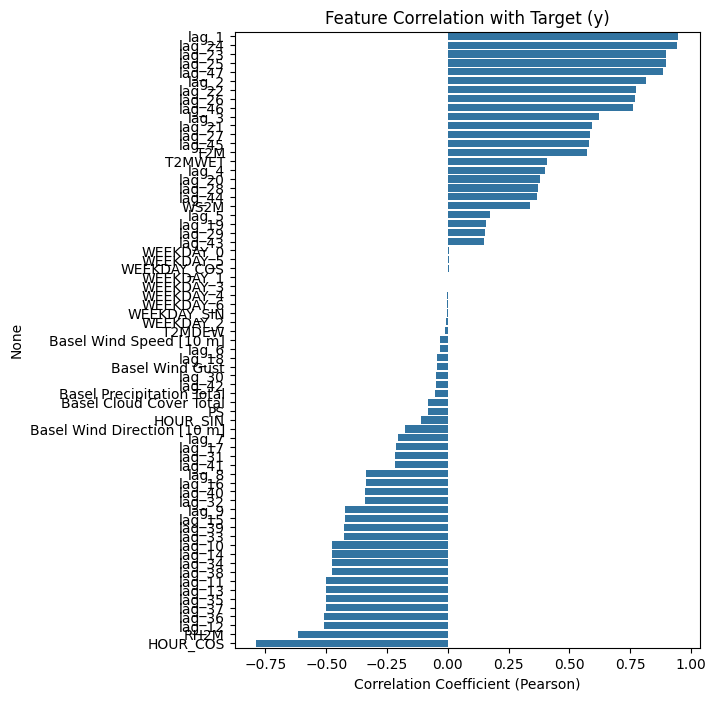

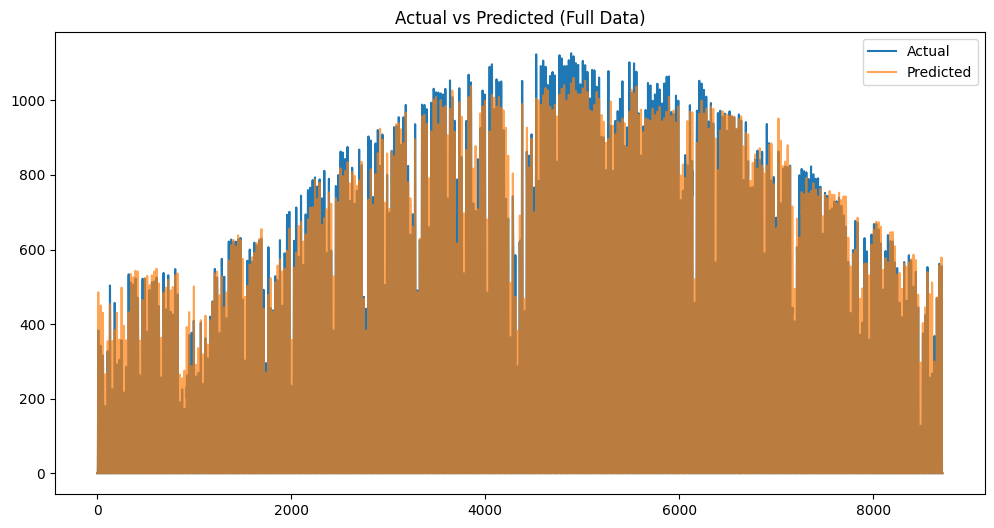

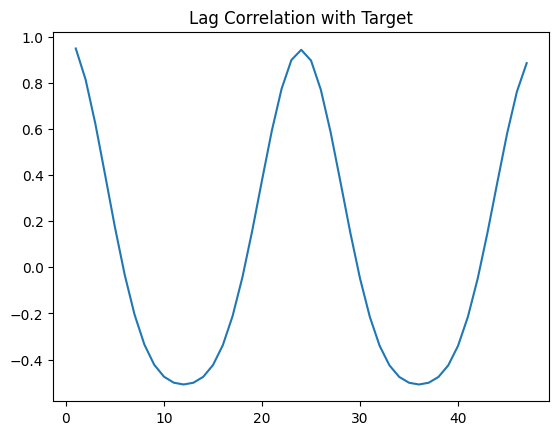

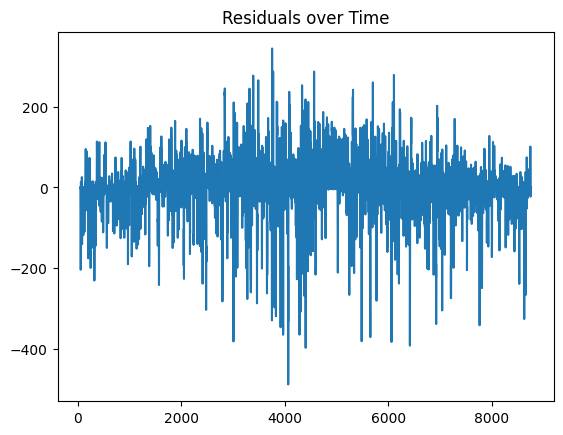

<Figure size 1400x1000 with 0 Axes>

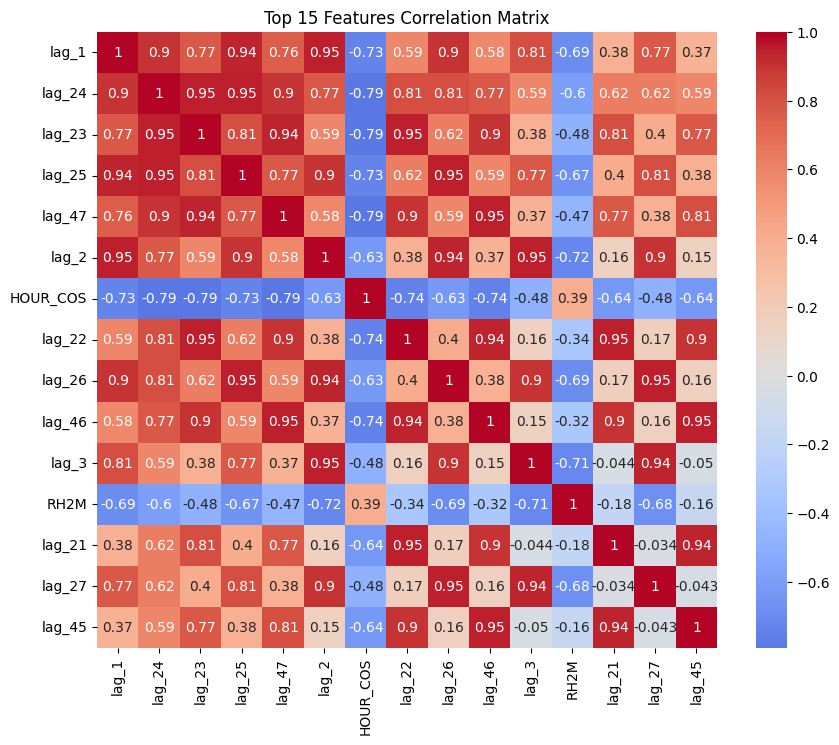

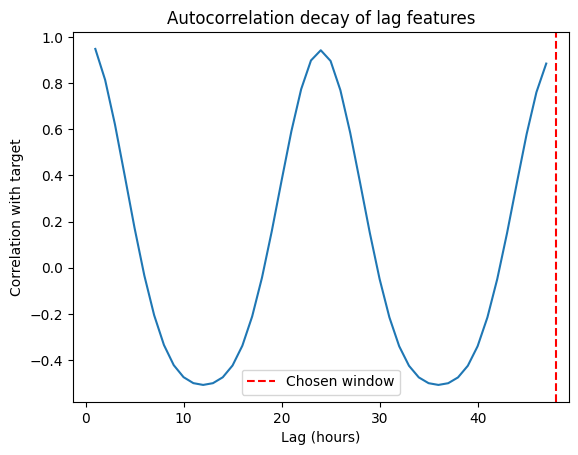


Evaluating WNN Demand Model on New Dataset...
MSE: 51709408.18, MAE: 7079.82, RMSE: 7190.93, R²: -22.93
Spearman ρ: 0.571, Kendall τ: 0.424
R² shuffled: -23.277


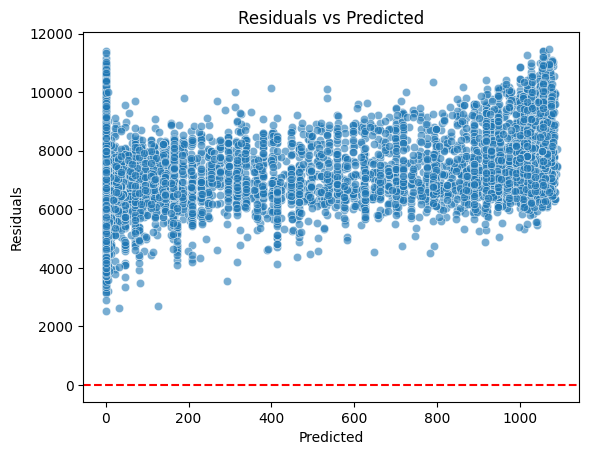

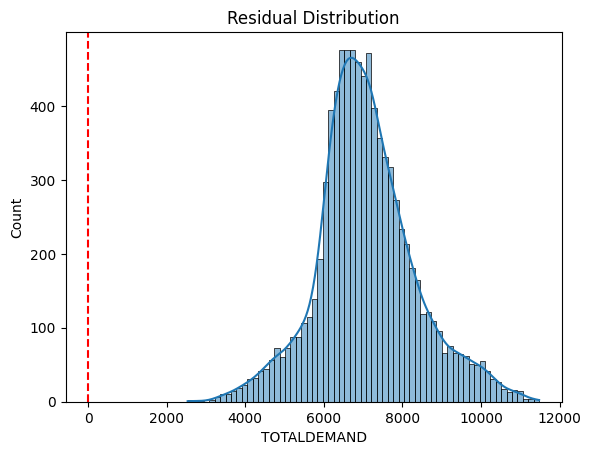

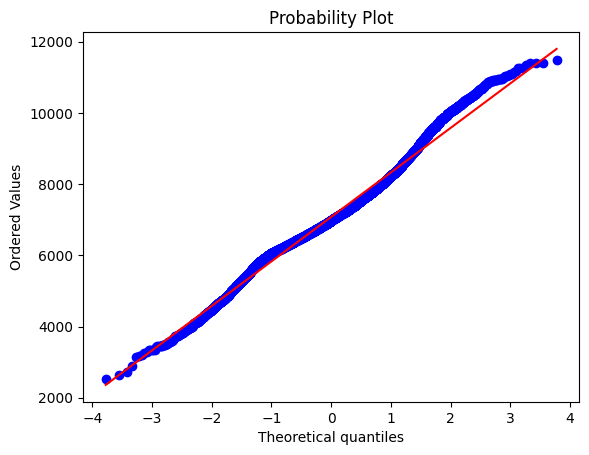

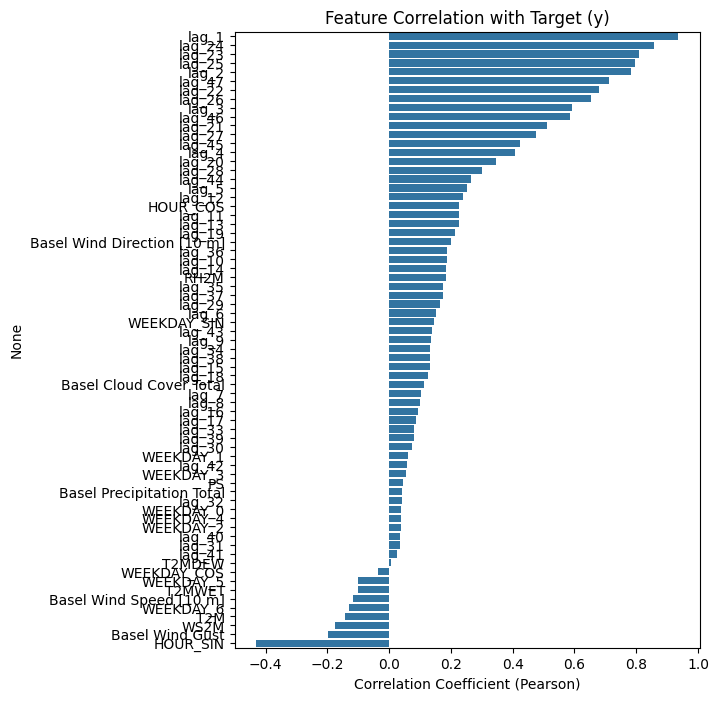

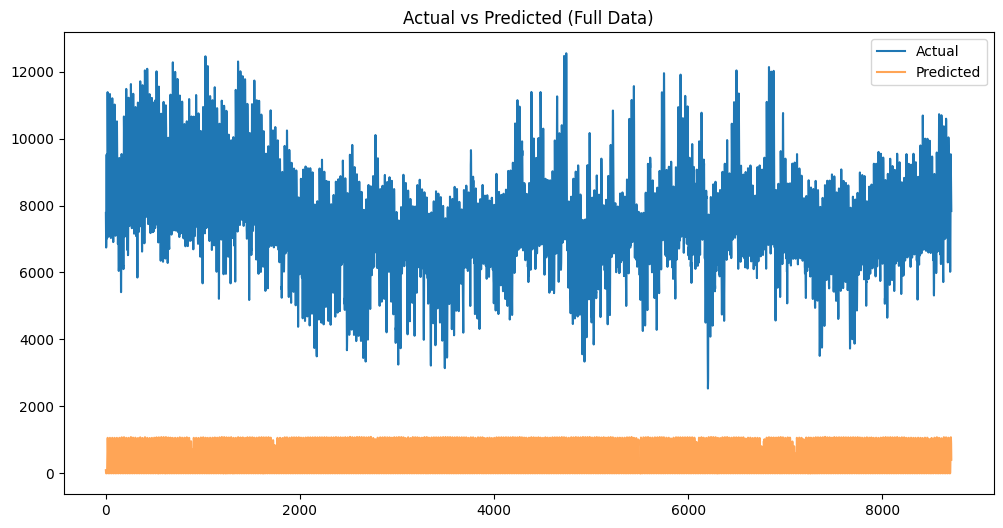

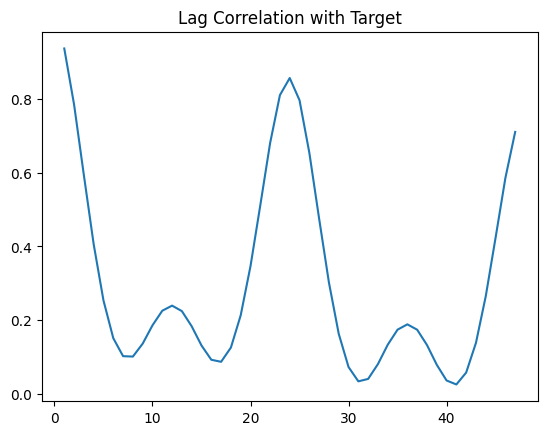

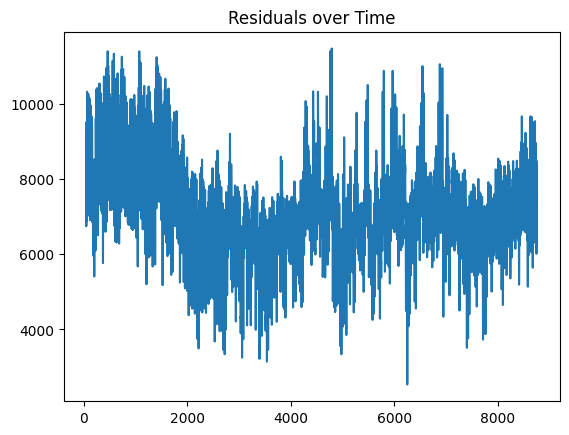

<Figure size 1400x1000 with 0 Axes>

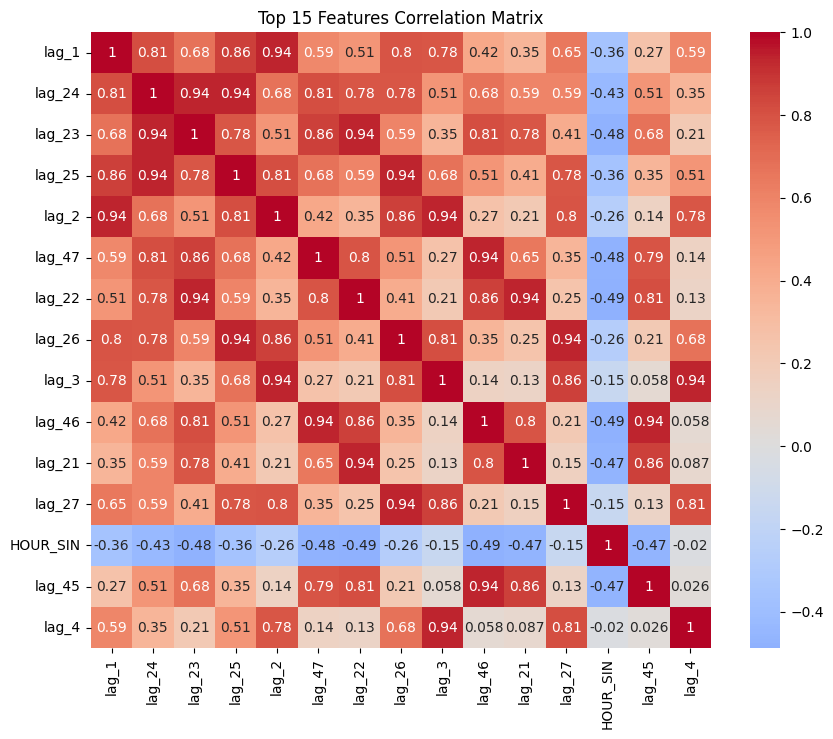

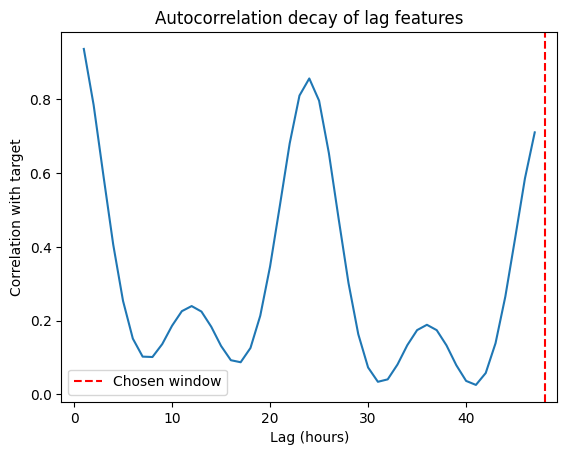

8713 8713


In [8]:
train_cols = list(X1.columns)
new_cols = list(X1_.columns)

missing = [c for c in train_cols if c not in new_cols]
extra   = [c for c in new_cols if c not in train_cols]

for col in X1.columns:
    print(col, X1[col].mean(), X1_[col].mean())


print(X1.describe().loc[['min','max','mean']])
print(X1_.describe().loc[['min','max','mean']])

train_corr = X1.corrwith(y1)
new_corr   = X1_.corrwith(y1_)

diff = (train_corr - new_corr).abs().sort_values(ascending=False)
print(diff.head(10))


print("Missing columns:", missing)
print("Extra columns:", extra)
print("Same shape:", len(train_cols) == len(new_cols))


print(f"\nEvaluating {model} Irradiance Model on New Dataset...")
y2_train = metrics_no_train(y2_, X2_, Solar_Pipeline)
print(f"\nEvaluating {model} Demand Model on New Dataset...")
y1_train = metrics_no_train(y1_, X1_, Demand_Pipeline)

print(len(y2_train), len(y1_train))
